In [1]:
### Load libraries -----
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio
from matplotlib import patches
from matplotlib.lines import Line2D
import plotly.express as px
import plotly.io as pio
import subprocess

In [2]:
### Set font in matplotlib -----
# Source: https://matplotlib.org/stable/tutorials/text/usetex.html
plt.rcParams.update({
"text.usetex": True,
"font.family": "serif",
"font.sans-serif": "mathpazo",
})

### Data Preparation

In [3]:
### Load ucdp data -------
# Codebook: https://ucdp.uu.se/downloads/ged/ged221.pdf
ucdp = pd.read_csv("https://ucdp.uu.se/downloads/ged/ged221-csv.zip", 
                  low_memory=False)
ucdp.head(3)

id               relid  year  active_year code_status  \
0  244657  IRQ-2017-1-524-322  2017            1       Clear   
1  412700  IRQ-2021-1-524-145  2021            1       Clear   
2  413023  IRQ-2021-1-524-143  2021            1       Clear   

   type_of_violence  conflict_dset_id  conflict_new_id     conflict_name  \
0                 1               259              259  Iraq: Government   
1                 1               259              259  Iraq: Government   
2                 1               259              259  Iraq: Government   

   dyad_dset_id  ...                 date_end deaths_a  deaths_b  \
0           524  ...  2017-07-31 00:00:00.000        0         4   
1           524  ...  2021-08-26 00:00:00.000       13         1   
2           524  ...  2021-08-28 00:00:00.000        0         2   

   deaths_civilians deaths_unknown  best  high  low  gwnoa gwnob  
0                 0              2     6     6    6    645   NaN  
1               141             28   183   184  171    645   NaN  
2                 0              0     2     3    0    645   NaN  

[3 rows x 49 columns]

In [4]:
### Get initial list of countries in Africa ------
list(ucdp["country_id"].loc[ucdp["region"]=="Africa"].unique())

[615,
 540,
 434,
 571,
 439,
 516,
 471,
 482,
 483,
 581,
 484,
 522,
 490,
 531,
 530,
 420,
 452,
 438,
 404,
 437,
 501,
 572,
 570,
 450,
 620,
 580,
 432,
 435,
 600,
 541,
 565,
 436,
 475,
 517,
 433,
 451,
 520,
 560,
 626,
 625,
 510,
 461,
 616,
 500,
 551,
 552]

In [5]:
### Convert ucdp df into geopandas df -------
# Source: https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
df_ucdp_geo = gpd.GeoDataFrame(
    ucdp, geometry=gpd.points_from_xy(ucdp.longitude, ucdp.latitude))
df_ucdp_geo.head(3)

id               relid  year  active_year code_status  \
0  244657  IRQ-2017-1-524-322  2017            1       Clear   
1  412700  IRQ-2021-1-524-145  2021            1       Clear   
2  413023  IRQ-2021-1-524-143  2021            1       Clear   

   type_of_violence  conflict_dset_id  conflict_new_id     conflict_name  \
0                 1               259              259  Iraq: Government   
1                 1               259              259  Iraq: Government   
2                 1               259              259  Iraq: Government   

   dyad_dset_id  ...  deaths_a deaths_b  deaths_civilians  deaths_unknown  \
0           524  ...         0        4                 0               2   
1           524  ...        13        1               141              28   
2           524  ...         0        2                 0               0   

  best  high  low gwnoa  gwnob                   geometry  
0    6     6    6   645    NaN  POINT (69.16280 34.53109)  
1  183   184  171   645    NaN  POINT (69.21722 34.56444)  
2    2     3    0   645    NaN  POINT (70.45575 34.42884)  

[3 rows x 50 columns]

In [6]:
### Subset countries in Africa ---------
# Take list of countries as point of departure and look up missing country codes here: 
# https://dornsife.usc.edu/assets/sites/298/docs/country_to_gwno_PUBLIC_6-5-2015.txt
# Source: https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
df_ucdp_geo_s = df_ucdp_geo[df_ucdp_geo["country_id"].isin(
      [615, 540, 434, 571, 439, 516, 471, 482, 483, 581, 484, 522, 490,
       531, 530, 420, 452, 438, 404, 437, 501, 572, 570, 450, 620, 580,
       432, 435, 600, 541, 565, 436, 475, 517, 433, 451, 520, 560, 626,
       625, 510, 461, 616, 500, 551, 552, 651, 553])]
df_ucdp_geo_s.head(3)

id           relid  year  active_year code_status  type_of_violence  \
41447  2629  ALG-1990-1-2-1  1990            0       Clear                 1   
41448  5751  ALG-1991-1-2-4  1991            1       Clear                 1   
41449  2587  ALG-1991-1-2-1  1991            1       Clear                 1   

       conflict_dset_id  conflict_new_id        conflict_name  dyad_dset_id  \
41447               386              386  Algeria: Government           827   
41448               386              386  Algeria: Government           827   
41449               386              386  Algeria: Government           827   

       ...  deaths_a deaths_b  deaths_civilians  deaths_unknown best  high  \
41447  ...         1        0                 0               0    1     1   
41448  ...         3        0                 0               0    3     3   
41449  ...         0        2                 1               1    4     4   

       low gwnoa  gwnob                  geometry  
41447    1   615    NaN  POINT (3.69123 36.14766)  
41448    3   615    NaN  POINT (6.88333 33.33333)  
41449    4   615    NaN  POINT (3.05056 36.76306)  

[3 rows x 50 columns]

In [7]:
### Load prio data ------
# Codebook: https://grid.prio.org/#/codebook
# Download data from: https://www.dropbox.com/s/kv2ey5yuvvoecvn/prio.csv.zip?dl=0 
# and place in working directory <----------- Read me
prio = pd.read_csv("prio.csv")
prio.head(3)

gid  year  agri_ih  barren_ih    bdist1    bdist2    bdist3   capdist  \
0  49182  1989      NaN        NaN  103.3474  103.3474  27.00977  2480.495   
1  49182  1990      NaN        NaN  103.3474  103.3474  27.00977  2480.495   
2  49182  2002      NaN        NaN  103.3474  103.3474  27.00977  2480.495   

   diamsec_y  diamprim_y  ...  pop_hyd_min  pop_hyd_sd  pop_hyd_sum  \
0        NaN         NaN  ...          NaN         NaN          NaN   
1        NaN         NaN  ...          0.0         0.0          0.0   
2        NaN         NaN  ...          NaN         NaN          NaN   

   prec_gpcc  prec_gpcp  savanna_ih  shrub_ih  temp  urban_ih  water_ih  
0   215.0550  1009.4620         NaN       NaN   NaN       NaN       NaN  
1   221.3225   984.8367         NaN       NaN   NaN       NaN       NaN  
2   188.1025   898.9387         NaN       NaN   NaN       NaN       NaN  

[3 rows x 61 columns]

In [8]:
### Replace missing values with mean ------
# Source: https://machinelearningmastery.com/handle-missing-data-python/
prio["nlights_mean"].fillna(prio["nlights_mean"].mean(), inplace=True)
prio["prec_gpcc"].fillna(prio["prec_gpcc"].mean(), inplace=True)

In [9]:
### Load prio grid ------
prio_shp = gpd.read_file('priogrid_cell.shp')
prio_shp.head(3)

gid  xcoord  ycoord  col  row  \
0  259168  163.75   89.75  688  360   
1  259169  164.25   89.75  689  360   
2  259170  164.75   89.75  690  360   

                                            geometry  
0  POLYGON ((163.50000 89.50000, 163.50000 90.000...  
1  POLYGON ((164.00000 89.50000, 164.00000 90.000...  
2  POLYGON ((164.50000 89.50000, 164.50000 90.000...

In [10]:
### Merge prio data with prio grid ------
# Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
df_prio = prio.merge(prio_shp, 
                     left_on='gid', 
                     right_on='gid', 
                     how="left")
df_prio.head(3)

gid  year  agri_ih  barren_ih    bdist1    bdist2    bdist3   capdist  \
0  49182  1989      NaN        NaN  103.3474  103.3474  27.00977  2480.495   
1  49182  1990      NaN        NaN  103.3474  103.3474  27.00977  2480.495   
2  49182  2002      NaN        NaN  103.3474  103.3474  27.00977  2480.495   

   diamsec_y  diamprim_y  ...  savanna_ih  shrub_ih  temp  urban_ih  water_ih  \
0        NaN         NaN  ...         NaN       NaN   NaN       NaN       NaN   
1        NaN         NaN  ...         NaN       NaN   NaN       NaN       NaN   
2        NaN         NaN  ...         NaN       NaN   NaN       NaN       NaN   

   xcoord  ycoord  col  row                                           geometry  
0  -69.25  -55.75  222   69  POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...  
1  -69.25  -55.75  222   69  POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...  
2  -69.25  -55.75  222   69  POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...  

[3 rows x 66 columns]

In [11]:
### Convert prio df into geopandas df --------
# Source: https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
df_prio_geo = gpd.GeoDataFrame(
    df_prio, geometry=gpd.points_from_xy(df_prio.xcoord, df_prio.ycoord))
df_prio_geo.head(3)

gid  year  agri_ih  barren_ih    bdist1    bdist2    bdist3   capdist  \
0  49182  1989      NaN        NaN  103.3474  103.3474  27.00977  2480.495   
1  49182  1990      NaN        NaN  103.3474  103.3474  27.00977  2480.495   
2  49182  2002      NaN        NaN  103.3474  103.3474  27.00977  2480.495   

   diamsec_y  diamprim_y  ...  savanna_ih  shrub_ih  temp  urban_ih  water_ih  \
0        NaN         NaN  ...         NaN       NaN   NaN       NaN       NaN   
1        NaN         NaN  ...         NaN       NaN   NaN       NaN       NaN   
2        NaN         NaN  ...         NaN       NaN   NaN       NaN       NaN   

   xcoord  ycoord  col  row                     geometry  
0  -69.25  -55.75  222   69  POINT (-69.25000 -55.75000)  
1  -69.25  -55.75  222   69  POINT (-69.25000 -55.75000)  
2  -69.25  -55.75  222   69  POINT (-69.25000 -55.75000)  

[3 rows x 66 columns]

In [12]:
### Subset countries in Africa ---------
# Take list of countries as point of departure and look up missing country codes here: 
# https://dornsife.usc.edu/assets/sites/298/docs/country_to_gwno_PUBLIC_6-5-2015.txt
# Source: https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
df_prio_geo_s = df_prio_geo[df_prio_geo["gwno"].isin(
       [615, 540, 434, 571, 439, 516, 471, 482, 483, 581, 484, 522, 490,
       531, 530, 420, 452, 438, 404, 437, 501, 572, 570, 450, 620, 580,
       432, 435, 600, 541, 565, 436, 475, 517, 433, 451, 520, 560, 626,
       625, 510, 461, 616, 500, 551, 552, 651, 553])]
df_prio_geo_s.head(3)

gid  year  agri_ih  barren_ih    bdist1    bdist2    bdist3   capdist  \
7904  62356  2011      NaN        NaN  1971.659  1971.659  8.620533  2482.531   
7905  62356  1995      NaN        NaN  1971.659  1971.659  8.620533  2482.531   
7906  62356  1989      NaN        NaN  1971.659  1971.659  8.620533  2482.531   

      diamsec_y  diamprim_y  ...  savanna_ih  shrub_ih      temp  urban_ih  \
7904        NaN         NaN  ...         NaN       NaN  5.615005       NaN   
7905        NaN         NaN  ...         NaN       NaN  5.261664       NaN   
7906        NaN         NaN  ...         NaN       NaN  5.510001       NaN   

      water_ih  xcoord  ycoord  col  row                    geometry  
7904       NaN   37.75  -46.75  436   87  POINT (37.75000 -46.75000)  
7905       NaN   37.75  -46.75  436   87  POINT (37.75000 -46.75000)  
7906       NaN   37.75  -46.75  436   87  POINT (37.75000 -46.75000)  

[3 rows x 66 columns]

In [13]:
### Aggregate ucdp event data to year-grid cell -----
# Source: https://stackoverflow.com/questions/39922986/how-do-i-pandas-group-by-to-get-sum
ucdp_s = df_ucdp_geo_s[["priogrid_gid", "year", "best"]]
ucdp_s = ucdp_s.groupby(["priogrid_gid", "year"])['best'].sum().reset_index()

In [14]:
### Merge prio and ucdp year-grid cell data -----
# Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
df = df_prio_geo_s.merge(ucdp_s, 
                         right_on=["year", "priogrid_gid"], 
                         left_on=["year", "gid"], 
                         how="left")
df.head(3)

gid  year  agri_ih  barren_ih    bdist1    bdist2    bdist3   capdist  \
0  62356  2011      NaN        NaN  1971.659  1971.659  8.620533  2482.531   
1  62356  1995      NaN        NaN  1971.659  1971.659  8.620533  2482.531   
2  62356  1989      NaN        NaN  1971.659  1971.659  8.620533  2482.531   

   diamsec_y  diamprim_y  ...      temp  urban_ih  water_ih  xcoord  ycoord  \
0        NaN         NaN  ...  5.615005       NaN       NaN   37.75  -46.75   
1        NaN         NaN  ...  5.261664       NaN       NaN   37.75  -46.75   
2        NaN         NaN  ...  5.510001       NaN       NaN   37.75  -46.75   

   col  row                    geometry  priogrid_gid  best  
0  436   87  POINT (37.75000 -46.75000)           NaN   NaN  
1  436   87  POINT (37.75000 -46.75000)           NaN   NaN  
2  436   87  POINT (37.75000 -46.75000)           NaN   NaN  

[3 rows x 68 columns]

In [15]:
### Fill missing values in fatalities variable with zero ------
# Source: https://stackoverflow.com/questions/13295735/how-to-replace-nan-values-by-zeroes-in-a-column-of-a-pandas-dataframe
df["best"].fillna(0, inplace=True)

# Sort by year
# Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
df.sort_values(by=["year"], inplace=True)
df.head(3)

gid  year  agri_ih  barren_ih    bdist1    bdist2    bdist3  \
65730   117750  1989      NaN        NaN  259.5540  259.5540  150.4549   
246274  170277  1989      NaN        NaN  352.1597  352.1597  352.1597   
70642   119934  1989      NaN        NaN  304.7759  304.7759  304.7759   

          capdist  diamsec_y  diamprim_y  ...      temp  urban_ih  water_ih  \
65730    179.0894        NaN         NaN  ...  23.21667       NaN       NaN   
246274  1045.8950        NaN         NaN  ...  24.69751       NaN       NaN   
70642   1294.8790        NaN         NaN  ...  23.88167       NaN       NaN   

        xcoord  ycoord  col  row                   geometry  priogrid_gid  \
65730    14.75   -8.25  390  164  POINT (14.75000 -8.25000)           NaN   
246274   -1.75   28.25  357  237  POINT (-1.75000 28.25000)           NaN   
70642    26.75   -6.75  414  167  POINT (26.75000 -6.75000)           NaN   

        best  
65730    0.0  
246274   0.0  
70642    0.0  

[3 rows x 68 columns]

### Choropleth and bubble maps 

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


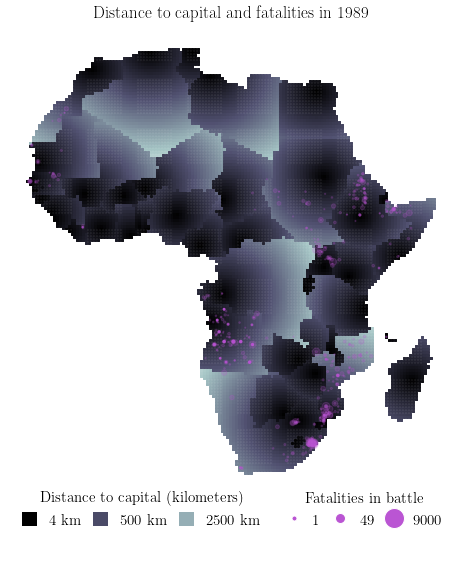

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


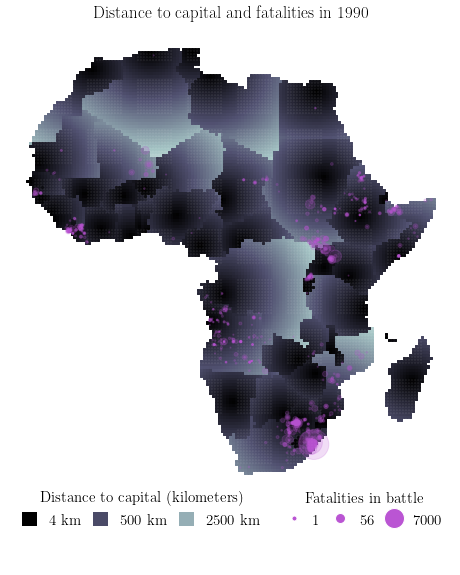

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


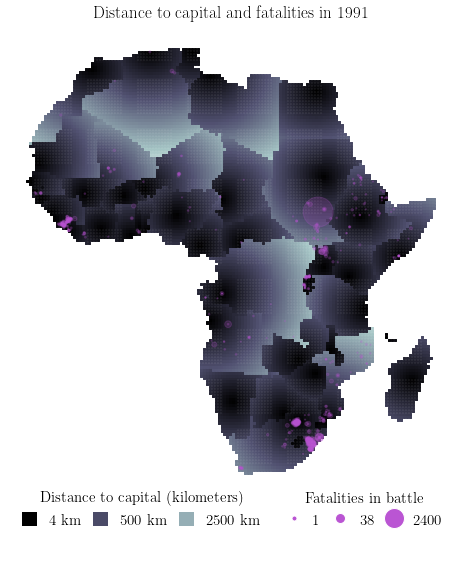

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


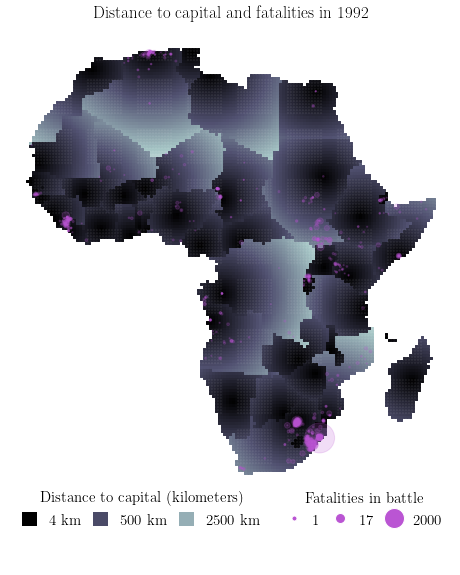

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


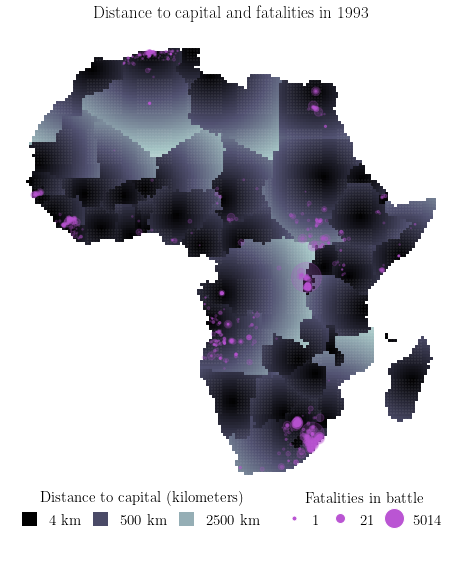

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


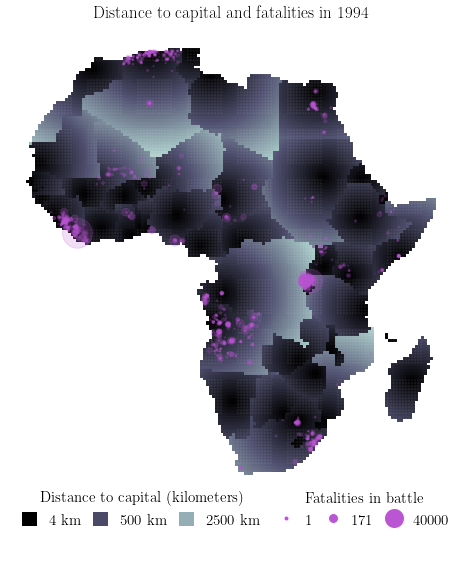

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


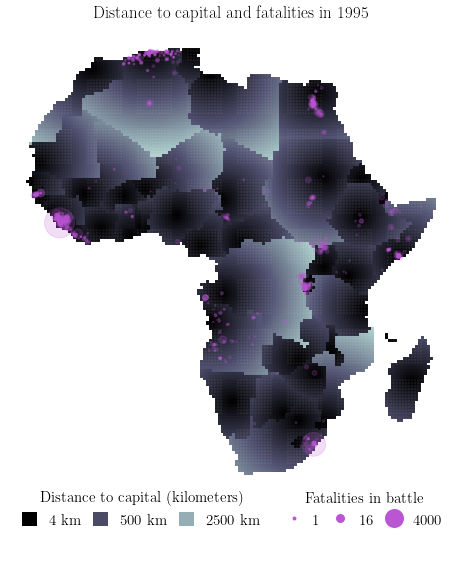

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


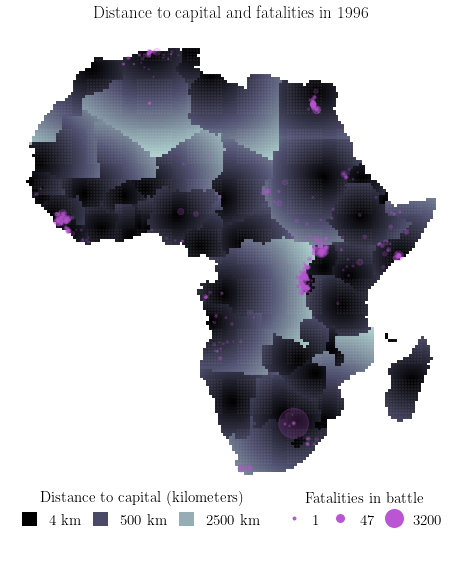

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


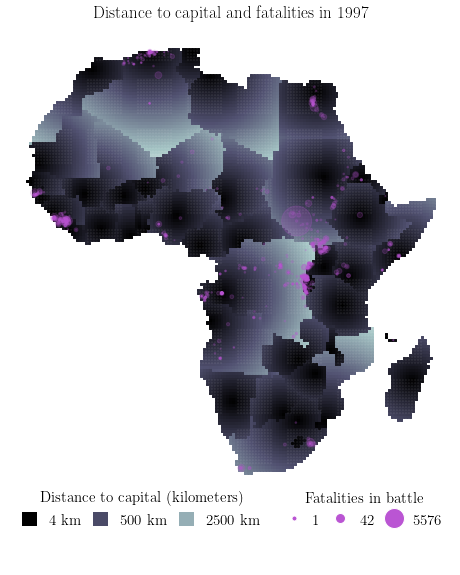

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


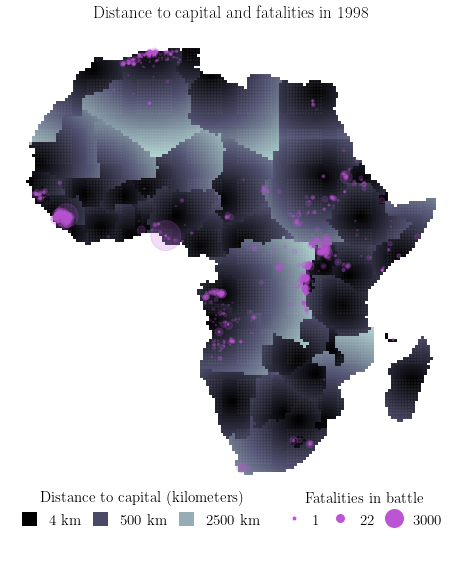

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


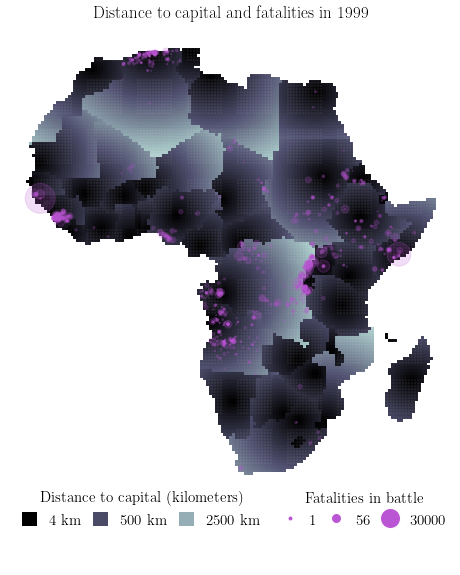

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


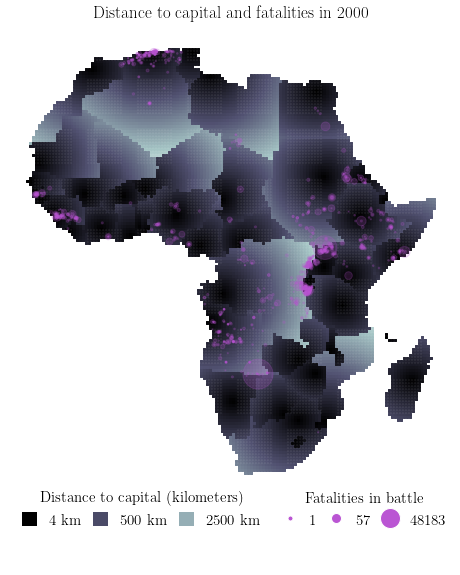

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


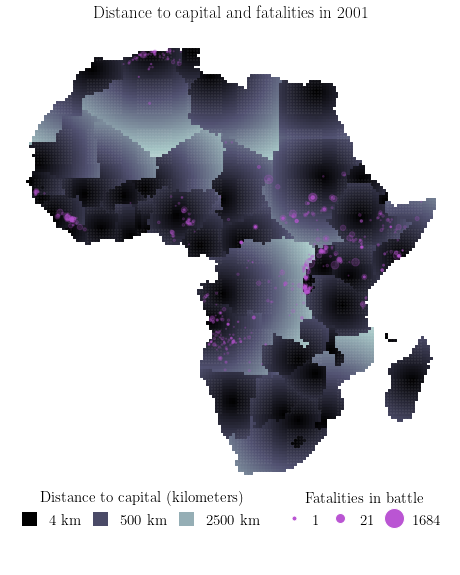

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


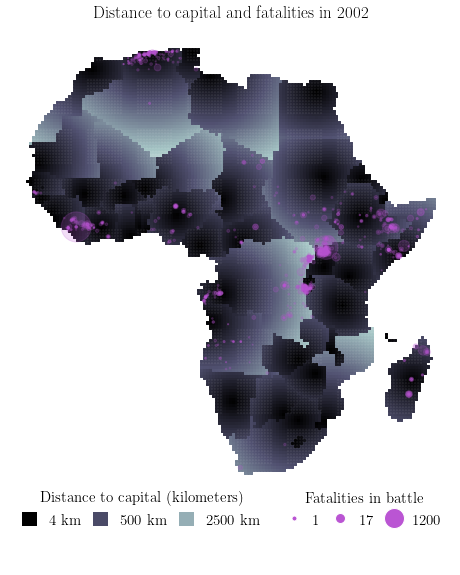

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


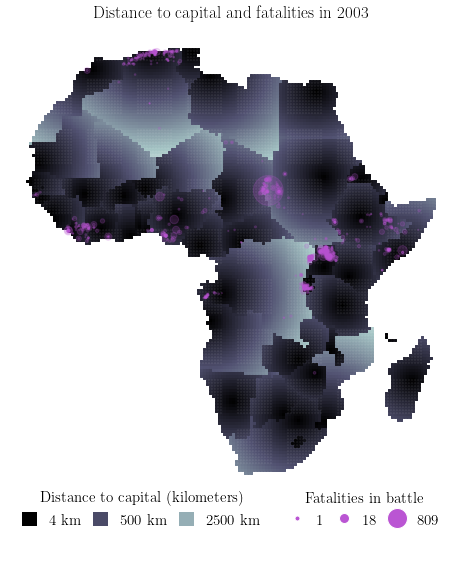

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


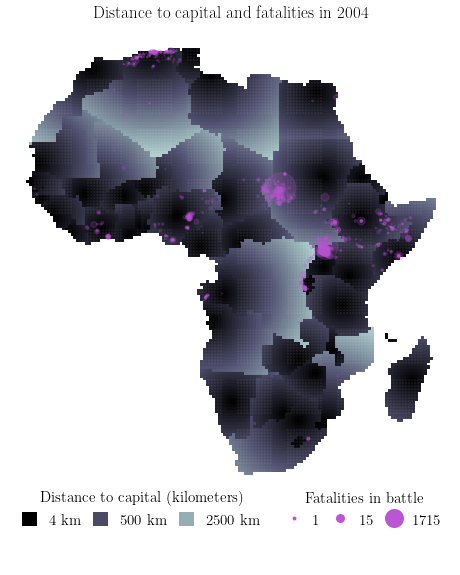

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


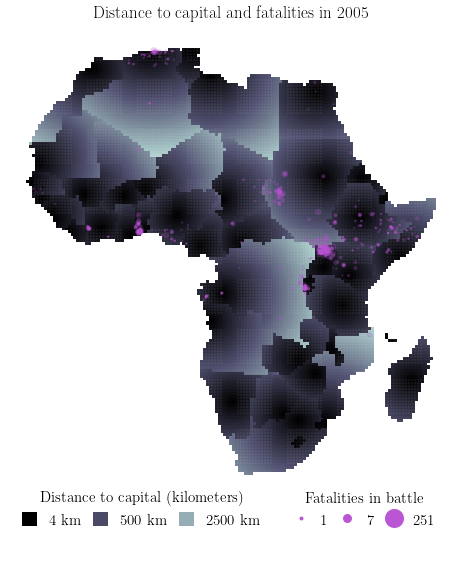

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


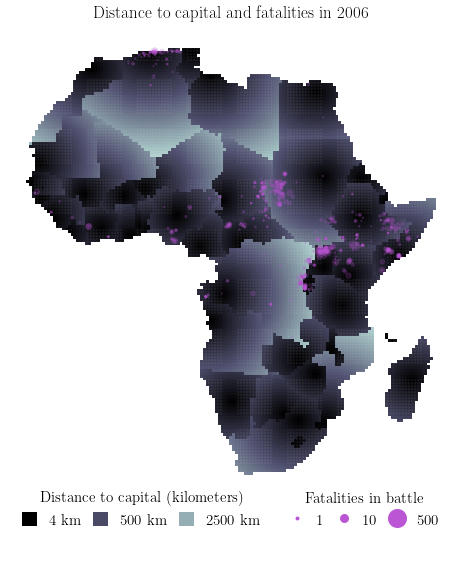

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


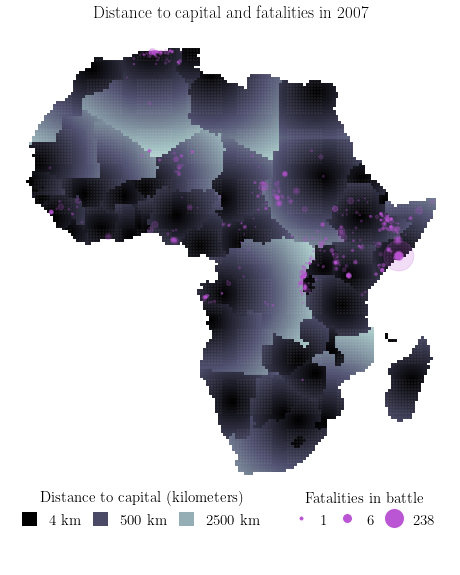

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


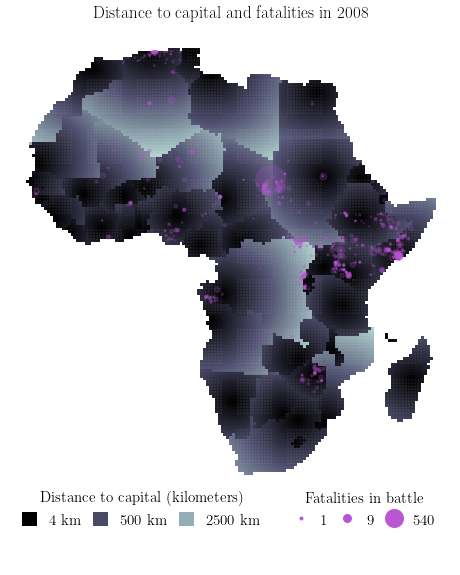

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


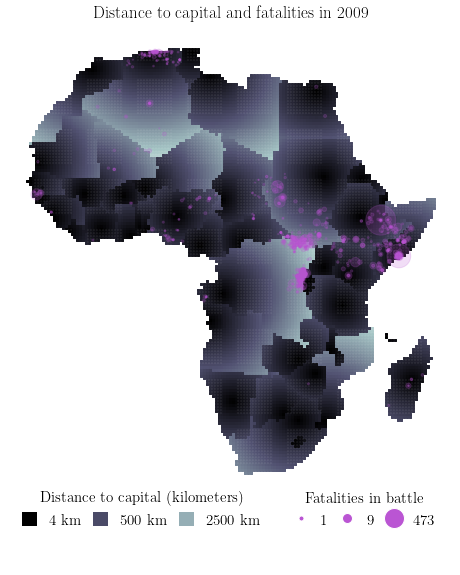

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


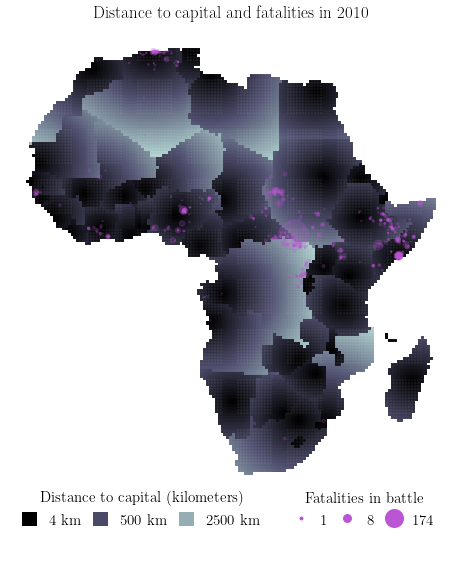

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


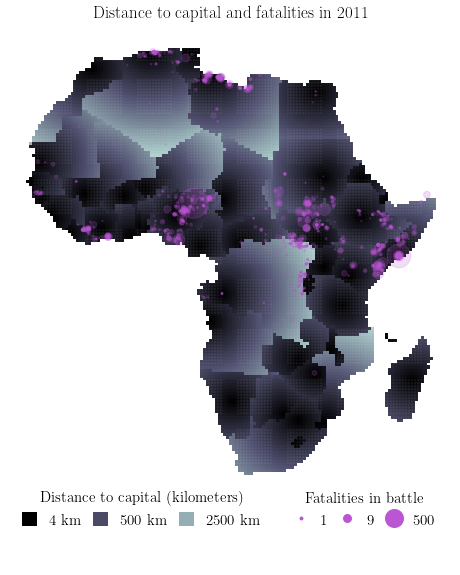

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


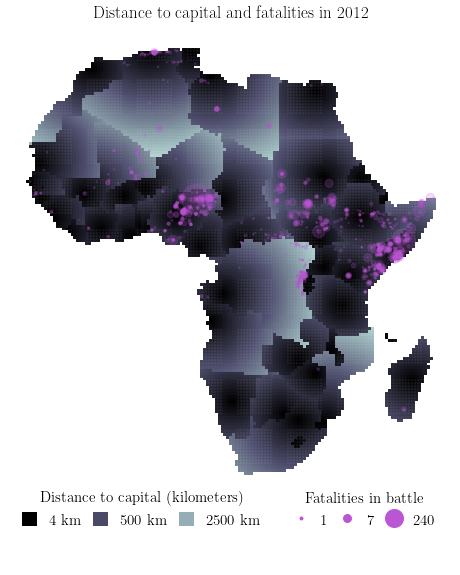

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


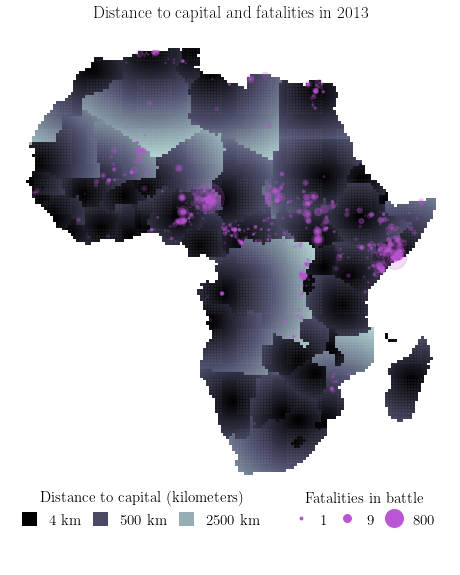

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


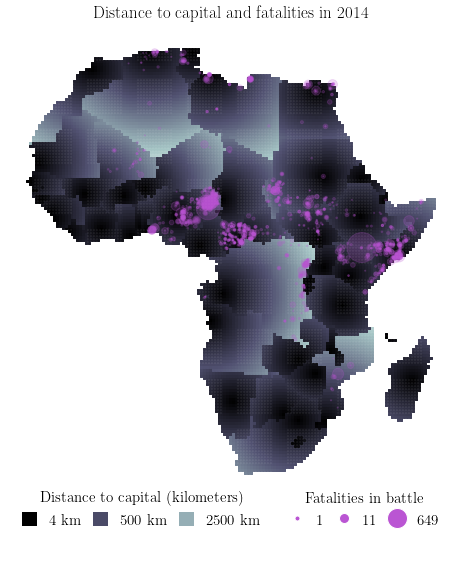

In [16]:
### Distance to capital ### -------

# For each year
for i in [1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 
 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 
 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0]:
    
    # Initiate plot
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # Remove axes
    # Source: https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
    plt.axis('off')
    
    # Plot
    # Adopted from: https://geopandas.org/en/stable/docs/user_guide/mapping.html
    df_prio_geo_s.loc[(df_prio_geo_s["year"]==i)].plot(column='capdist',
                                                       ax=ax, 
                                                       marker='s', 
                                                       markersize=5, 
                                                       cmap="bone")
    
    df_ucdp_geo_s.loc[(df_ucdp_geo_s["year"]==i)].plot(column='best',
                                                       ax=ax, 
                                                       marker='o', 
                                                       markersize=df_ucdp_geo_s["best"]*1.5, 
                                                       color="mediumorchid", 
                                                       alpha=0.2)
    
    plt.title(f"Distance to capital and fatalities in {int(i)}", size=17)
    
    # Get color map
    # Source: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
    cmap = plt.cm.get_cmap('bone', 4)
    
    # Manually define legend entries
    # Sources: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
    # https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
    entries1 = [patches.Rectangle((0,0),1,1, facecolor=cmap(0), label='4 km'),
                patches.Rectangle((0,0),1,1, facecolor=cmap(1), label='500 km'),
                patches.Rectangle((0,0),1,1, facecolor=cmap(2), label='2500 km')]    
    
    # Modify legend
    # Sources: https://www.geeksforgeeks.org/use-multiple-columns-in-a-matplotlib-legend/
    # https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
    # https://stackoverflow.com/questions/25540259/remove-or-adapt-border-of-frame-of-legend-using-matplotlib
    # https://stackoverflow.com/questions/44620013/title-for-matplotlib-legend
    # https://stackoverflow.com/questions/72521182/how-to-reduce-space-between-columns-in-a-horizontal-legend-python
    # https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    legend1 = plt.legend(handles=entries1, 
               loc='lower center',
               bbox_to_anchor=(0.3,0.05),
               ncol=3,
               handlelength=1, 
               handleheight=1,
               columnspacing=0.8,
               frameon=False,
               title="Distance to capital (kilometers)",
               prop={'size': 15})
    
    # Increase legend title size
    # Source: https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
    plt.setp(legend1.get_title(), fontsize=15)
    
    # Multiple legends 
    # Source: https://www.tutorialspoint.com/drawing-multiple-legends-on-the-same-axes-in-matplotlib
    plt.gca().add_artist(legend1)
    
    # Manually define legend entries, change labels for each year
    # Sources: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
    entries2 = [Line2D([0], [0],
                       marker='o', 
                       color='w', 
                       markerfacecolor='mediumorchid', 
                       label=1, 
                       markersize=5),
               Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor='mediumorchid', 
                      label=f'{round(df_ucdp_geo_s["best"].loc[(df_ucdp_geo_s["year"]==i)].mean())}',
                      markersize=10),
               Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor='mediumorchid', 
                      label=f'{round(df_ucdp_geo_s["best"].loc[(df_ucdp_geo_s["year"]==i)].max())}',
                      markersize=20)]
    
    # Modify legend
    # See sources above.
    legend2 = plt.legend(handles=entries2, 
               loc='lower center', 
               ncol=3,
               bbox_to_anchor=(0.8,0.05),
               handlelength=1, 
               handleheight=1,
               columnspacing=0.8,
               frameon=False,
               title="Fatalities in battle",
               prop={'size': 15})

    # Increase legend title size
    # Source: https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
    plt.setp(legend2.get_title(), fontsize=15)
    
    plt.savefig(f"map_capdist_{int(i)}.jpeg", 
                dpi=400)
    
    plt.show()

In [17]:
### Save as gif -------
# Source: https://towardsdatascience.com/probably-the-easiest-way-to-animate-your-python-plots-f5194ebed75f
with imageio.get_writer('animation_capdis.gif', mode='i') as out:
    
    # For each year
    for i in [1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 
              1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
              2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]:
        frame = imageio.imread(f'map_capdist_{i}.jpeg')
        out.append_data(frame)

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


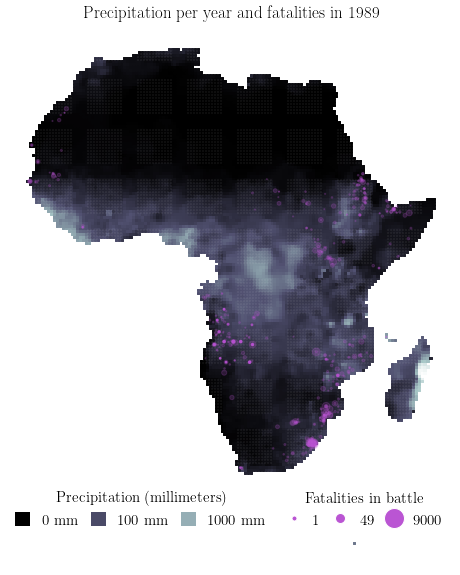

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


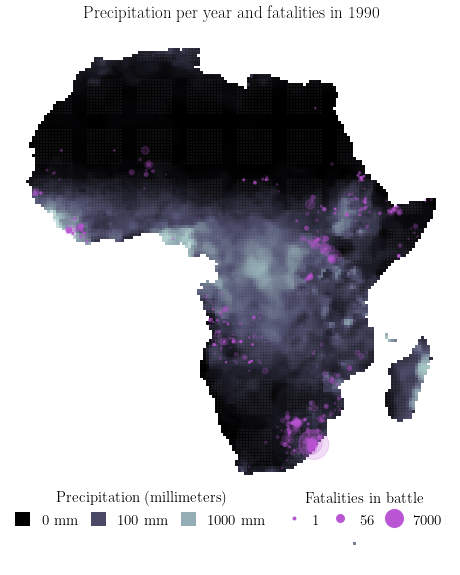

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


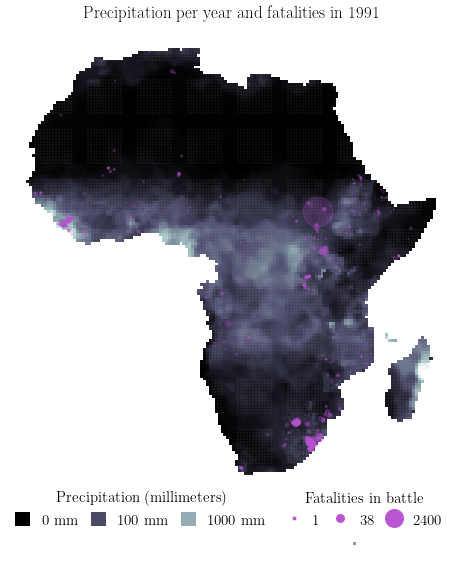

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


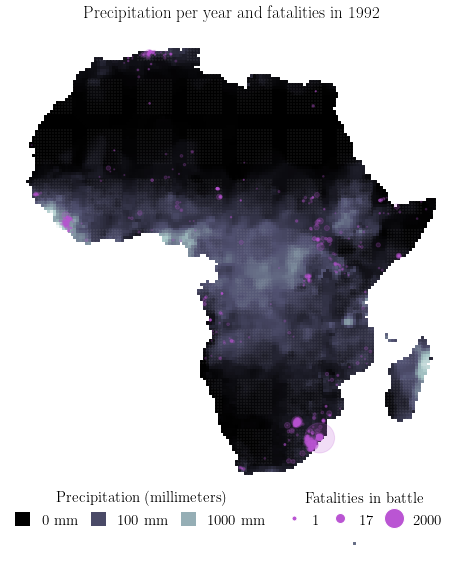

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


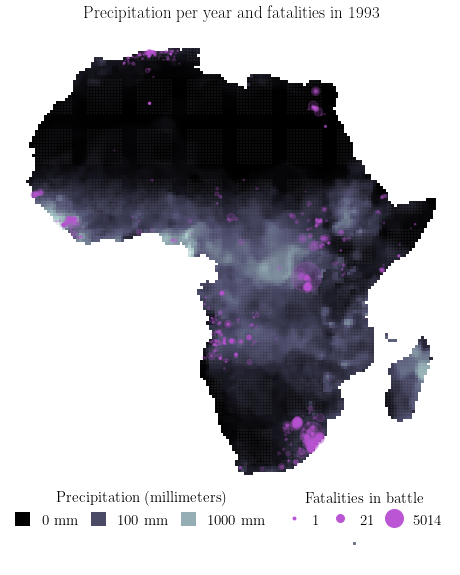

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


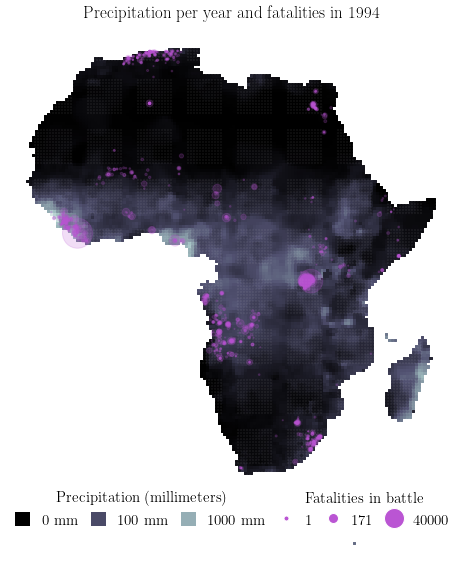

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


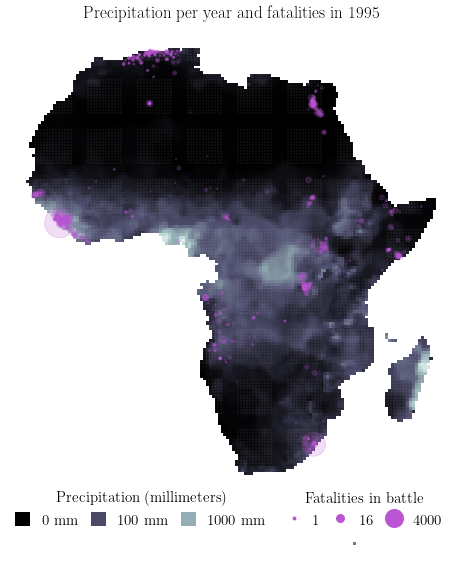

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


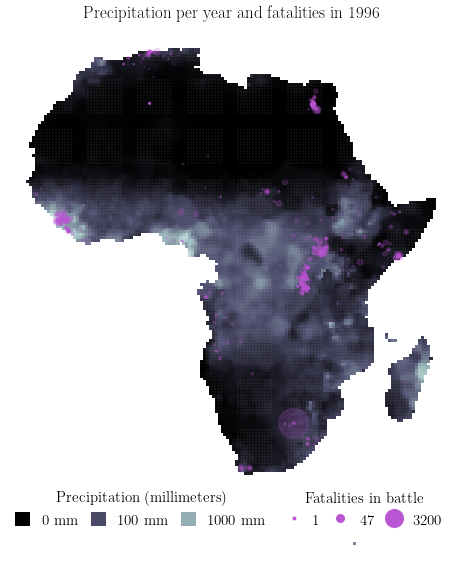

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


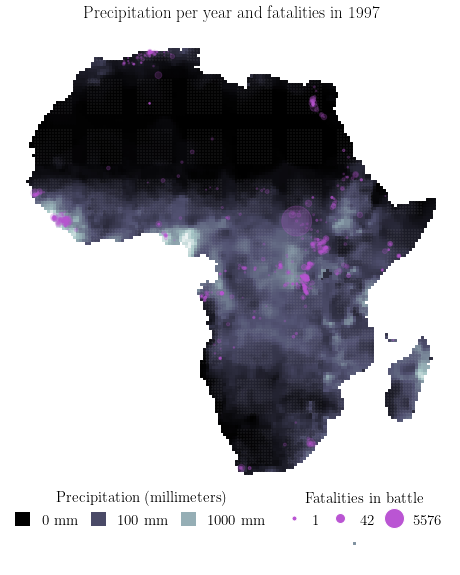

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


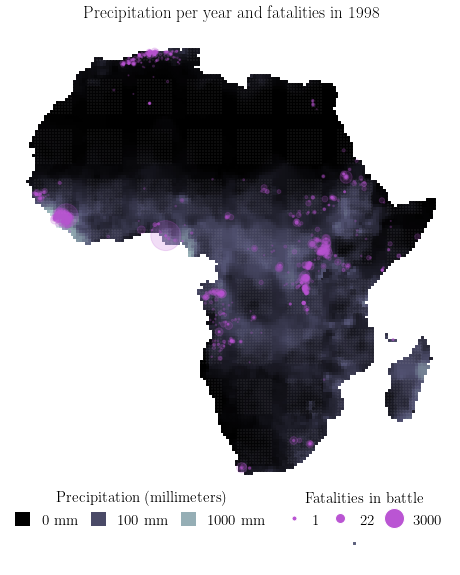

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


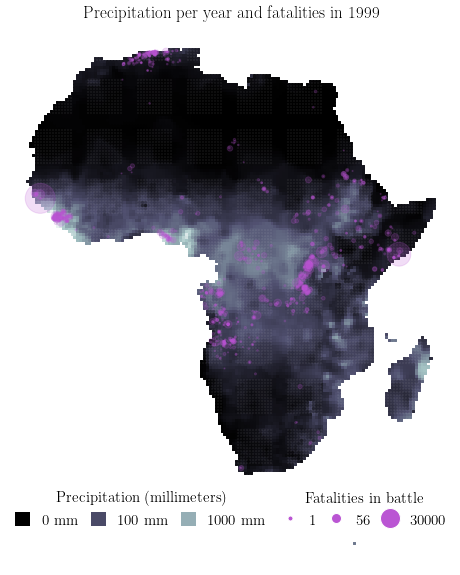

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


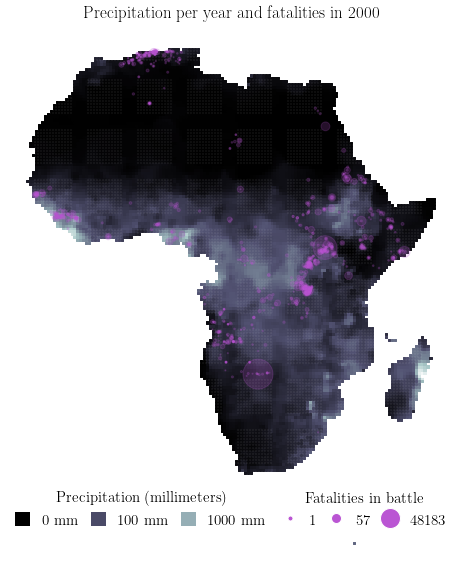

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


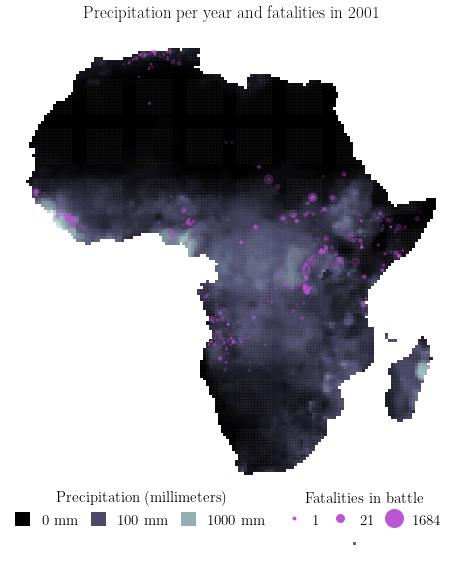

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


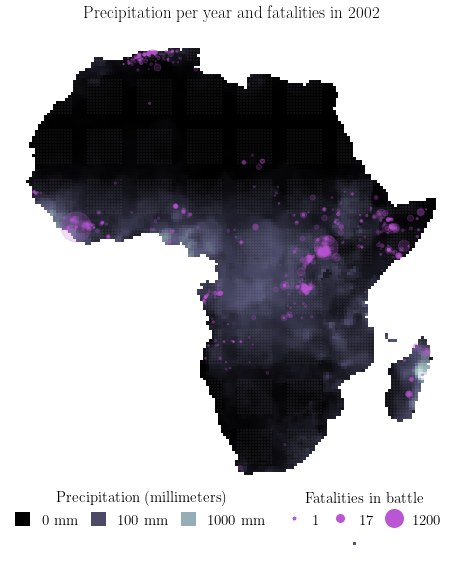

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


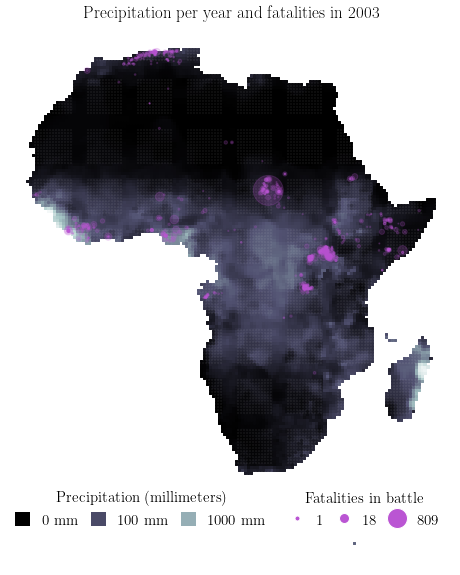

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


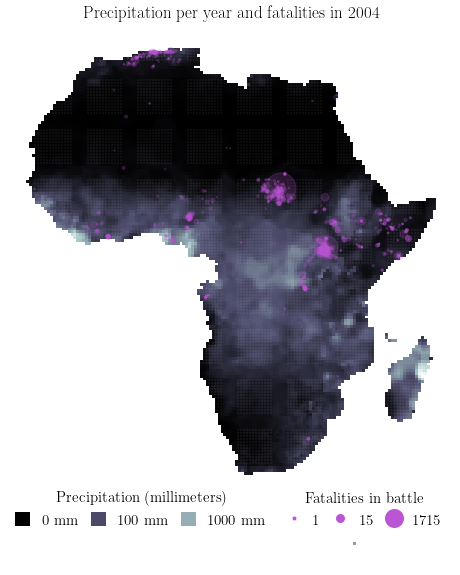

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


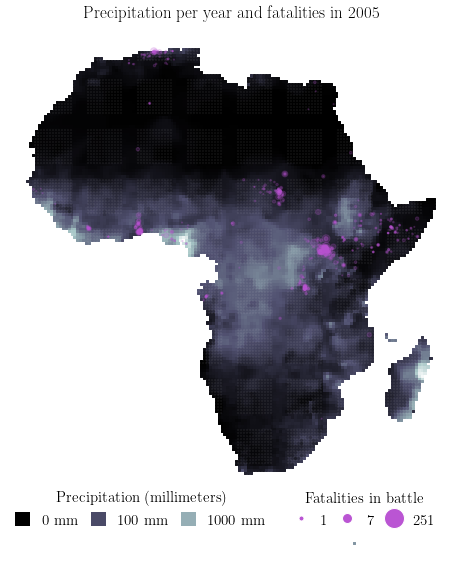

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


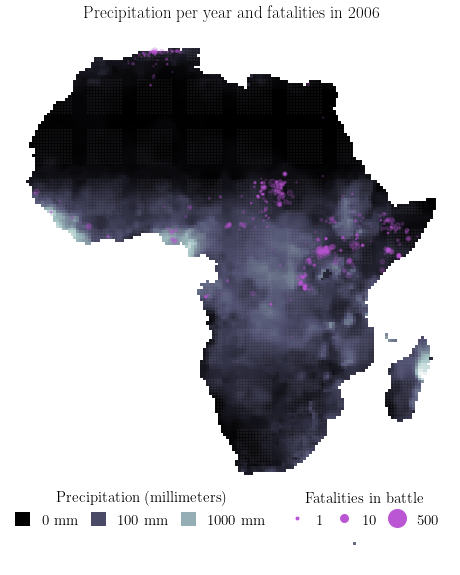

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


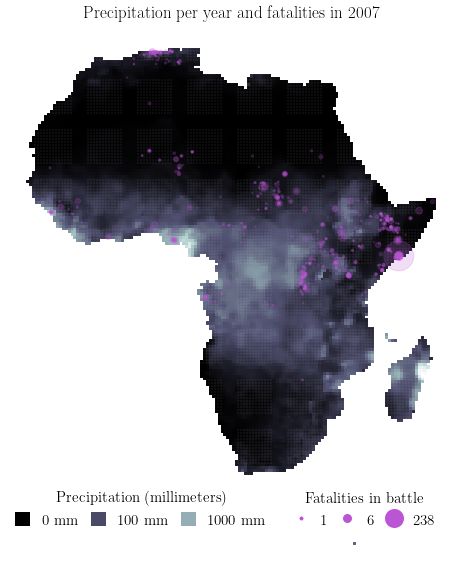

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


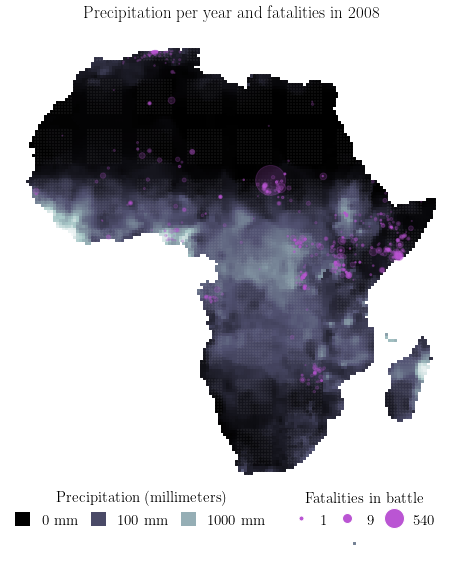

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


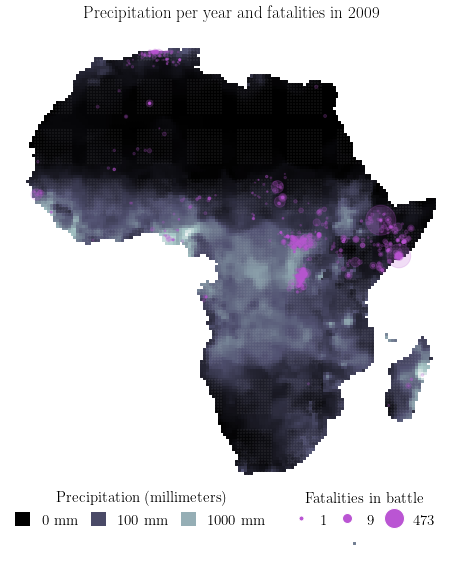

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


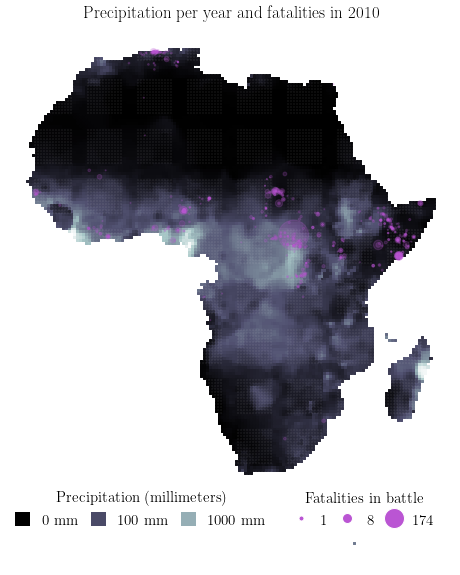

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


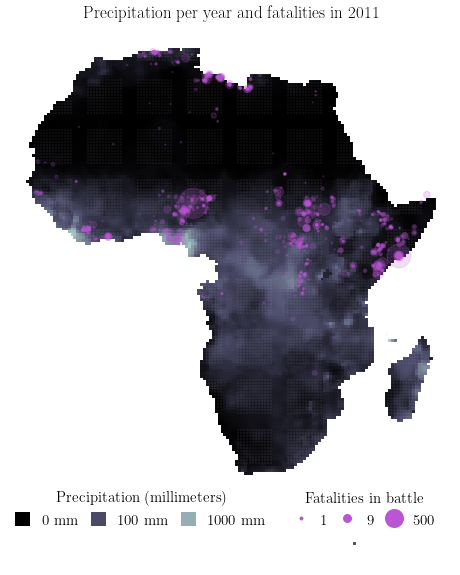

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


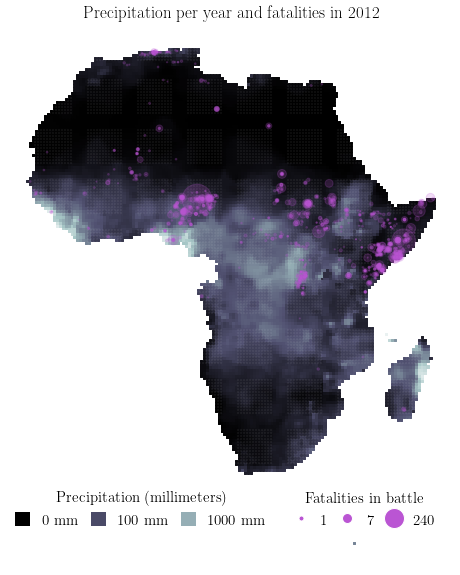

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


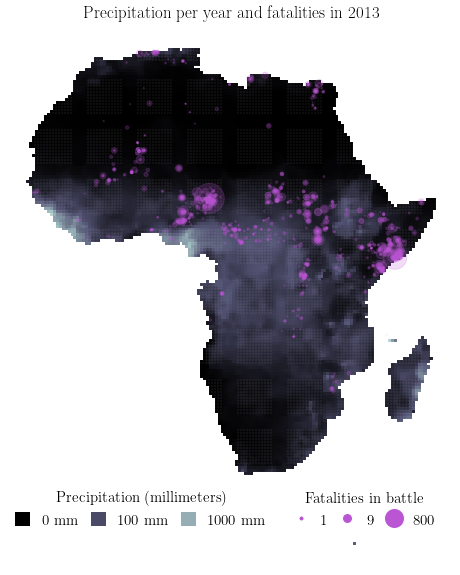

In [18]:
### Precipitation per year ### ------

# For each year
for i in [1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 
 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 
 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0]:
    
    # Initiate plot
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # Remove axes
    # Source: https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
    plt.axis('off')
    
    # Plot
    # Adopted from: https://geopandas.org/en/stable/docs/user_guide/mapping.html
    df_prio_geo_s.loc[(df_prio_geo_s["year"]==i)].plot(column='prec_gpcc', 
                                                       ax=ax, 
                                                       marker='s', 
                                                       markersize=5, 
                                                       cmap="bone")
    
    df_ucdp_geo_s.loc[(df_ucdp_geo_s["year"]==i)].plot(column='best', 
                                                          ax=ax, 
                                                          marker='o', 
                                                          markersize=df_ucdp_geo_s["best"]*1.5, 
                                                          color="mediumorchid", 
                                                          alpha=0.2)

    plt.title(f"Precipitation per year and fatalities in {int(i)}", size=17)
    
    # Get color map
    # Source: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
    cmap = plt.cm.get_cmap('bone', 4)
    
    # Manually define legend entries
    # Sources: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
    # https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
    entries1 = [patches.Rectangle((0,0),1,1, facecolor=cmap(0), label='0 mm'),
                patches.Rectangle((0,0),1,1, facecolor=cmap(1), label='100 mm'),
                patches.Rectangle((0,0),1,1, facecolor=cmap(2), label='1000 mm')]    
    
    # Modify legend
    # Source: https://www.geeksforgeeks.org/use-multiple-columns-in-a-matplotlib-legend/
    # https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
    # https://stackoverflow.com/questions/25540259/remove-or-adapt-border-of-frame-of-legend-using-matplotlib
    # https://stackoverflow.com/questions/44620013/title-for-matplotlib-legend
    # https://stackoverflow.com/questions/72521182/how-to-reduce-space-between-columns-in-a-horizontal-legend-python
    # https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    legend1 = plt.legend(handles=entries1, 
               loc='lower center',
               bbox_to_anchor=(0.3,0.05),
               ncol=3,
               handlelength=1, 
               handleheight=1,
               columnspacing=0.8,
               frameon=False,
               title="Precipitation (millimeters)", 
               prop={'size': 15})
    
    # Increase legend title size
    # Source: https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
    plt.setp(legend1.get_title(),fontsize=15)
    
    # Multiple legends
    # Source: https://www.tutorialspoint.com/drawing-multiple-legends-on-the-same-axes-in-matplotlib
    plt.gca().add_artist(legend1)
    
    # Manually define legend entries
    # Sources: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
    entries2 = [Line2D([0], [0],
                       marker='o', 
                       color='w', 
                       markerfacecolor='mediumorchid', 
                       label=1, 
                       markersize=5),
               Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor='mediumorchid', 
                      label=f'{round(df_ucdp_geo_s["best"].loc[(df_ucdp_geo_s["year"]==i)].mean())}',
                      markersize=10),
               Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor='mediumorchid', 
                      label=f'{round(df_ucdp_geo_s["best"].loc[(df_ucdp_geo_s["year"]==i)].max())}',
                      markersize=20)]
    
    # Modify legend
    # See sources above.
    legend2 = plt.legend(handles=entries2, 
               loc='lower center', 
               ncol=3,
               bbox_to_anchor=(0.8,0.05),
               handlelength=1, 
               handleheight=1,
               columnspacing=0.8,
               frameon=False,
               title="Fatalities in battle",
               prop={'size': 15})
    
    # Increase legend title size
    # Source: https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
    plt.setp(legend2.get_title(),fontsize=15)

    plt.savefig(f"map_prec_gpcc_{int(i)}.jpeg", 
                dpi=400)
    
    plt.show()

In [19]:
### Save as gif -------
# Source: https://towardsdatascience.com/probably-the-easiest-way-to-animate-your-python-plots-f5194ebed75f
with imageio.get_writer('animation_prec_gpcc.gif', mode='i') as out:
    
    # For each year
    for i in [1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 
              1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
              2007, 2008, 2009, 2010, 2011, 2012, 2013]:
        frame = imageio.imread(f'map_prec_gpcc_{i}.jpeg')
        out.append_data(frame)

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


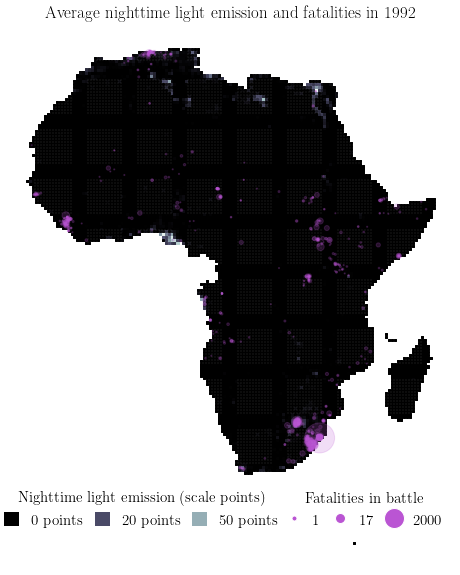

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


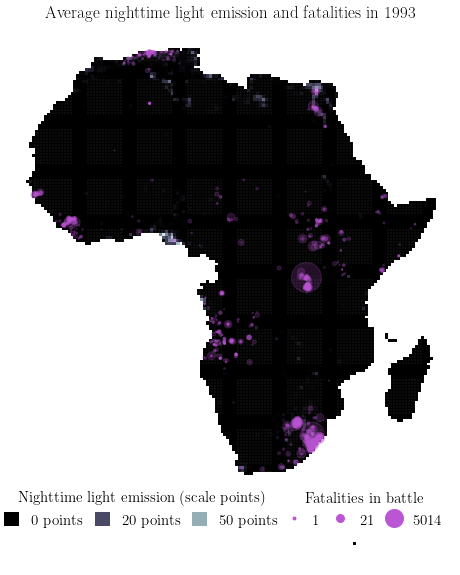

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


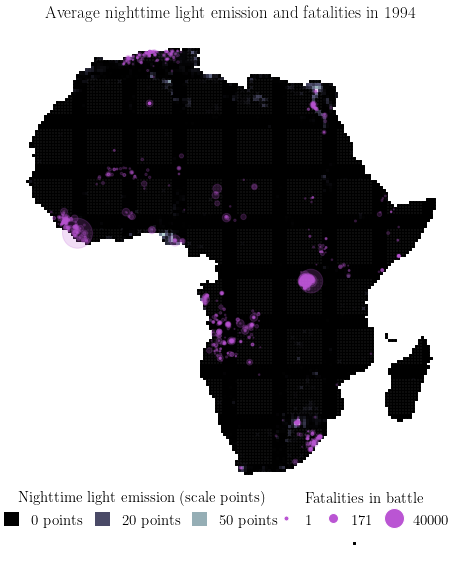

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


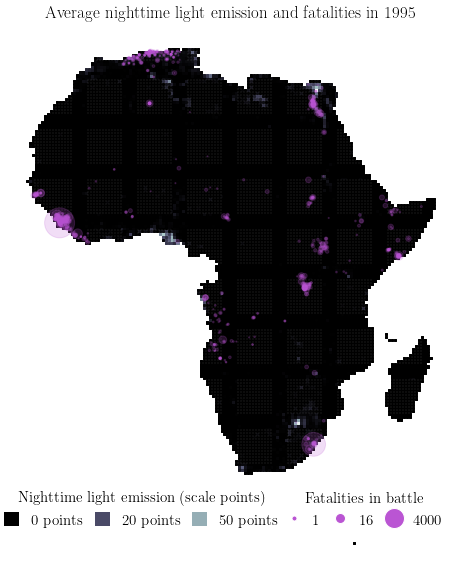

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


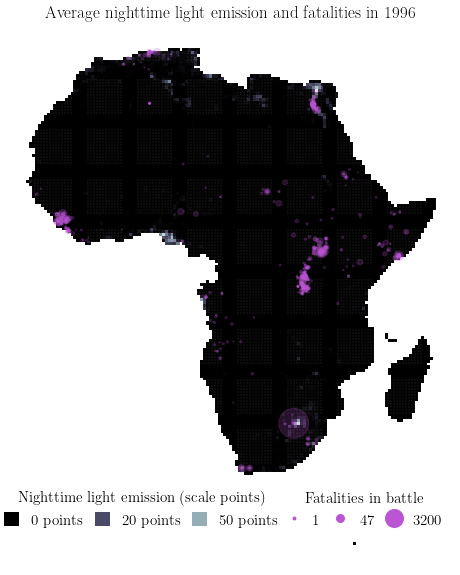

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


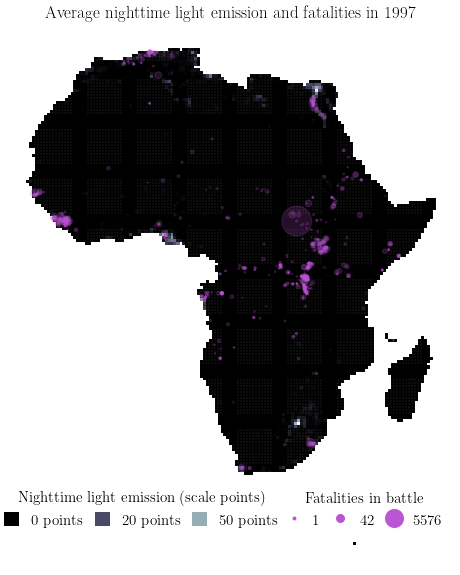

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


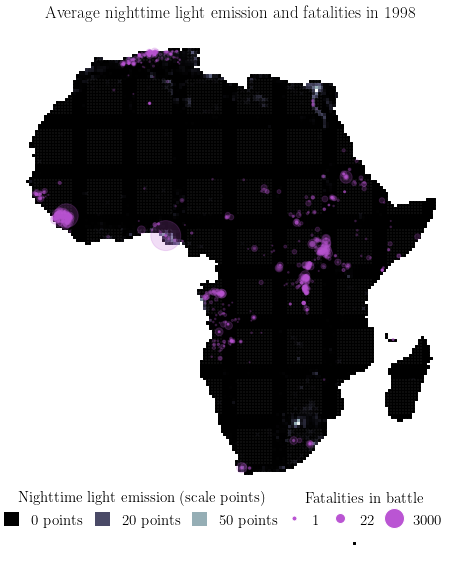

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


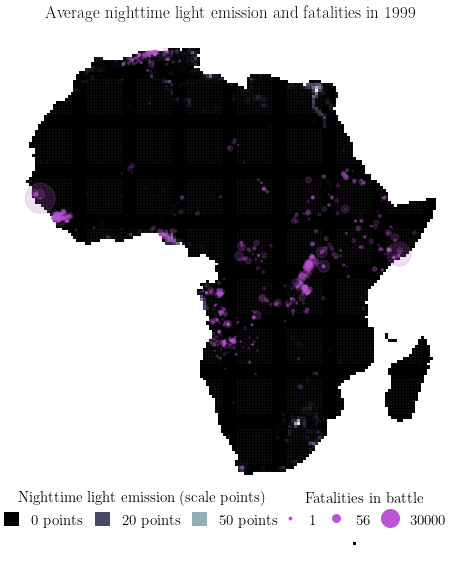

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


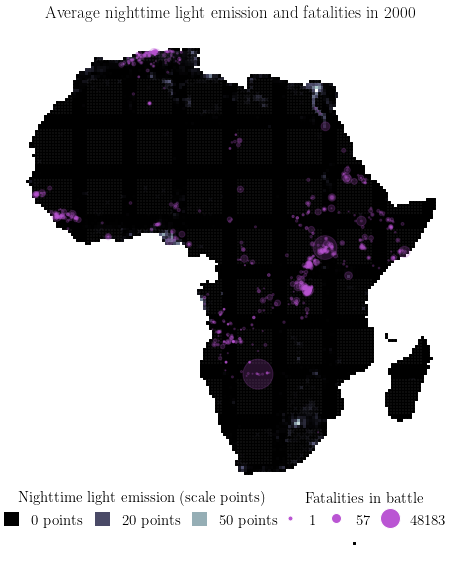

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


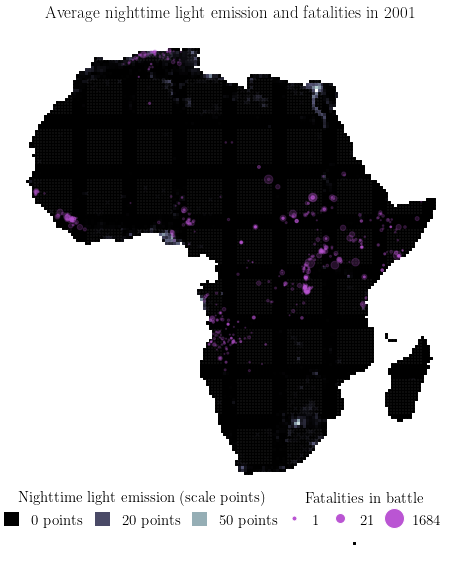

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


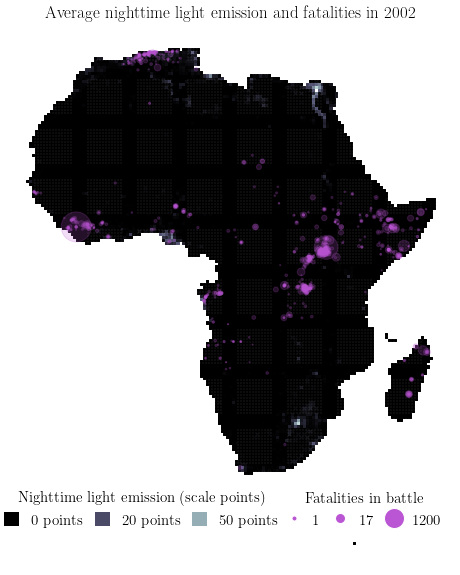

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


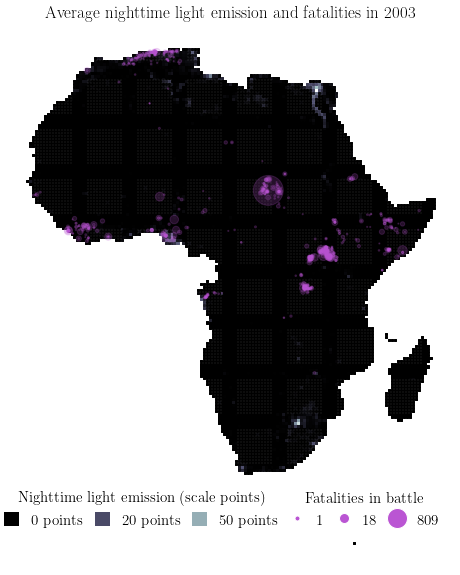

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


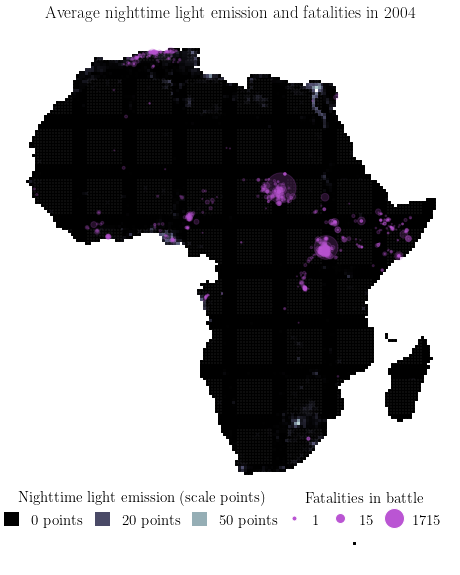

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


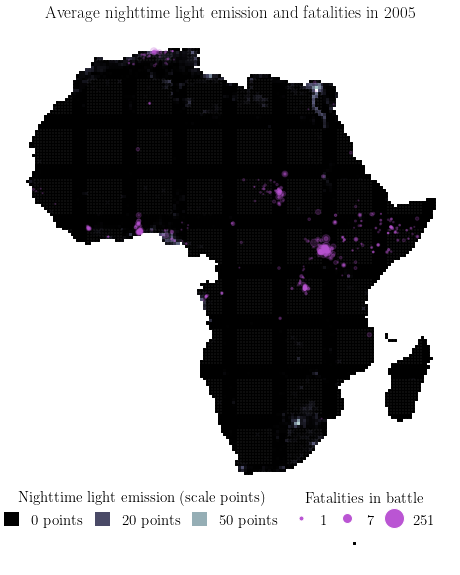

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


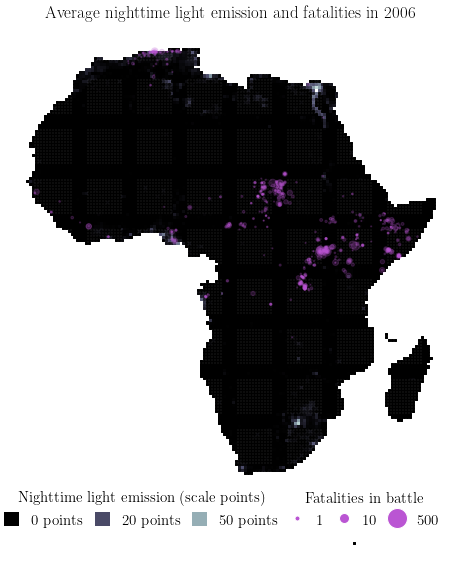

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


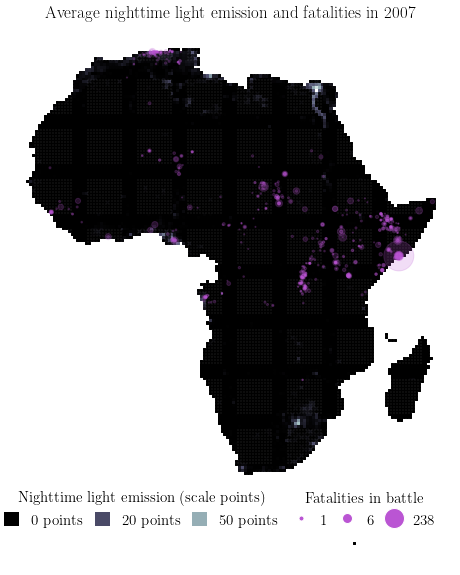

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


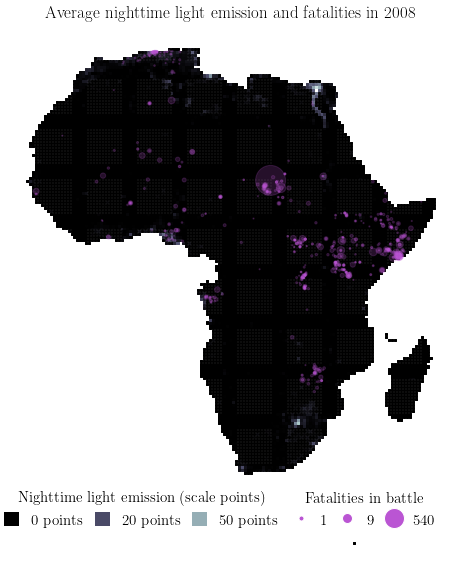

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


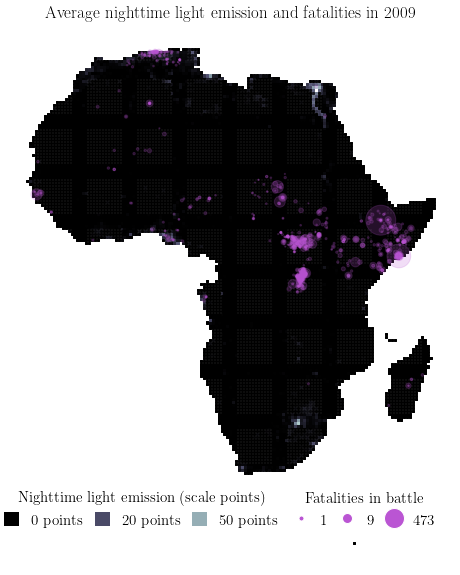

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


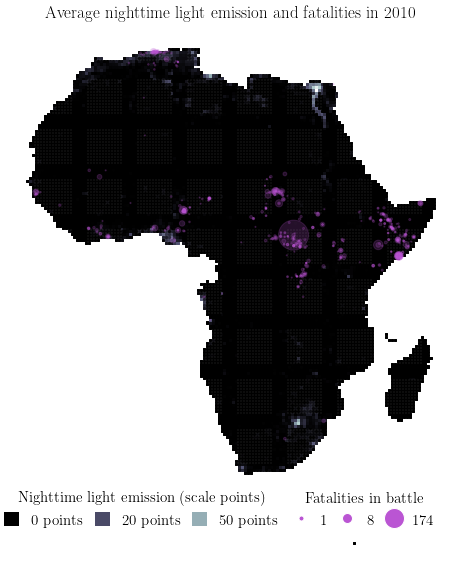

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


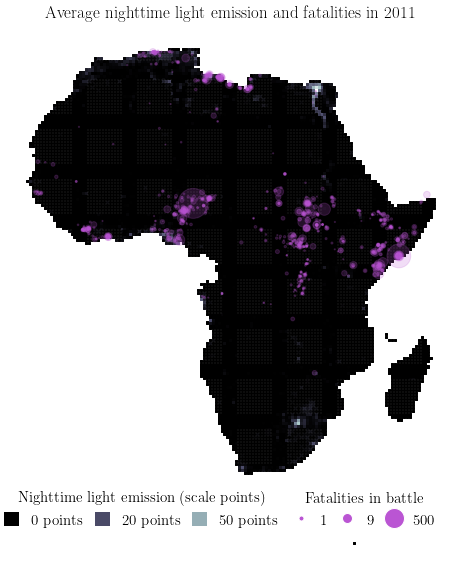

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


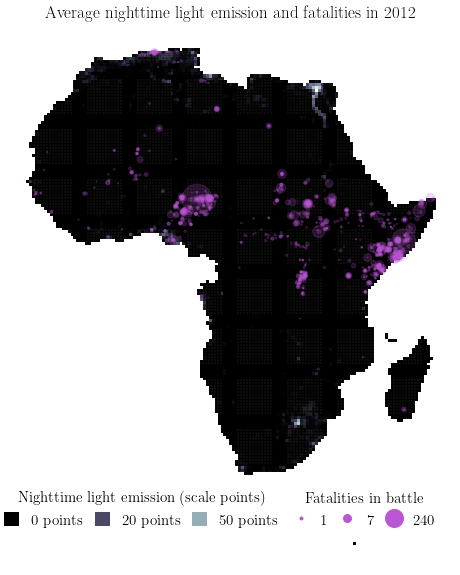

/Users/hannahfrank/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


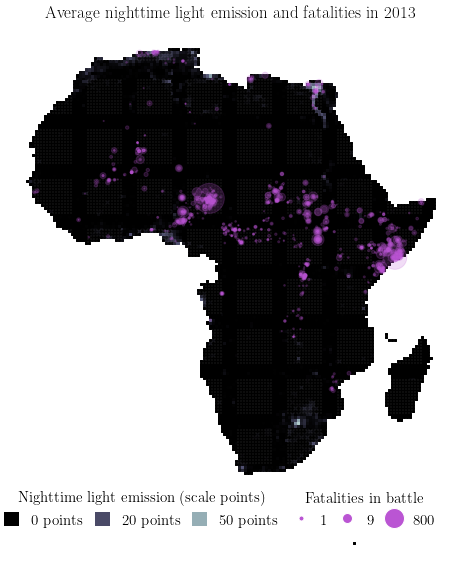

In [20]:
### Average nighttime light emission ### ------

# For each year
for i in [1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 
 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 
 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0]:
    
    # Initiate plot
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # Remove axes
    # Source: https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
    plt.axis('off')
    
    # Plot
    # Adopted from: https://geopandas.org/en/stable/docs/user_guide/mapping.html
    df_prio_geo_s.loc[(df_prio_geo_s["year"]==i)].plot(column='nlights_mean', 
                                                       ax=ax, 
                                                       marker='s', 
                                                       markersize=5, 
                                                       cmap="bone")
    
    df_ucdp_geo_s.loc[(df_ucdp_geo_s["year"]==i)].plot(column='best', 
                                                          ax=ax, 
                                                          marker='o', 
                                                          markersize=df_ucdp_geo_s["best"]*1.5, 
                                                          color="mediumorchid", 
                                                          alpha=0.2)
    
    plt.title(f"Average nighttime light emission and fatalities in {int(i)}", size=17)
    
    # Get color map
    # Source: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib
    cmap = plt.cm.get_cmap('bone', 4)
    
    # Manually define legend entries
    # Sources: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
    # https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
    entries1 = [patches.Rectangle((0,0),1,1, facecolor=cmap(0), label='0 points'),
                patches.Rectangle((0,0),1,1, facecolor=cmap(1), label='20 points'),
                patches.Rectangle((0,0),1,1, facecolor=cmap(2), label='50 points')]    
    
    # Modify legend
    # Source: https://www.geeksforgeeks.org/use-multiple-columns-in-a-matplotlib-legend/
    # https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
    # https://stackoverflow.com/questions/25540259/remove-or-adapt-border-of-frame-of-legend-using-matplotlib
    # https://stackoverflow.com/questions/44620013/title-for-matplotlib-legend
    # https://stackoverflow.com/questions/72521182/how-to-reduce-space-between-columns-in-a-horizontal-legend-python
    # https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    legend1 = plt.legend(handles=entries1, 
               loc='lower center',
               bbox_to_anchor=(0.3,0.05),
               ncol=3,
               handlelength=1, 
               handleheight=1,
               columnspacing=0.8,
               frameon=False,
               title="Nighttime light emission (scale points)", 
               prop={'size': 15})
    
    # Increase legend title size
    # Source: https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
    plt.setp(legend1.get_title(),fontsize=15)
    
    # Multiple legends 
    # Source: https://www.tutorialspoint.com/drawing-multiple-legends-on-the-same-axes-in-matplotlib
    plt.gca().add_artist(legend1)
    
    # Manually define legend entries
    # Sources: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
    entries2 = [Line2D([0], [0],
                       marker='o', 
                       color='w', 
                       markerfacecolor='mediumorchid', 
                       label=1, 
                       markersize=5),
               Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor='mediumorchid', 
                      label=f'{round(df_ucdp_geo_s["best"].loc[(df_ucdp_geo_s["year"]==i)].mean())}',
                      markersize=10),
               Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor='mediumorchid', 
                      label=f'{round(df_ucdp_geo_s["best"].loc[(df_ucdp_geo_s["year"]==i)].max())}',
                      markersize=20)]
    
    # Modify legend
    # See sources above.
    legend2 = plt.legend(handles=entries2, 
               loc='lower center', 
               ncol=3,
               bbox_to_anchor=(0.8,0.05),
               handlelength=1, 
               handleheight=1,
               columnspacing=0.8,
               frameon=False,
               title="Fatalities in battle", 
               prop={'size': 15})
    
    # Increase legend title size
    # Source: https://stackoverflow.com/questions/12402561/how-to-set-font-size-of-matplotlib-axis-legend
    plt.setp(legend2.get_title(),fontsize=15)

    plt.savefig(f"map_nlights_mean_{int(i)}.jpeg", 
                dpi=400)
    
    plt.show()


In [ ]:
### Save as gif -------
# Source: https://towardsdatascience.com/probably-the-easiest-way-to-animate-your-python-plots-f5194ebed75f

# For each year
with imageio.get_writer('animation_nlights_mean.gif', mode='i') as out:
    for i in [1992, 1993, 1994, 1995, 1996, 1997, 1998,  
              1999, 2000, 2001, 2002, 2003, 2004, 2005,
              2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]:
        frame = imageio.imread(f'map_nlights_mean_{i}.jpeg')
        out.append_data(frame)

### Scatter plots

In [ ]:
### Check maximum values -----
print(df.capdist.max())

# Sort fatalities variable 
# Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
df.sort_values(by="best", ascending=False).head(16)
# Note that 15 extreme observations are not included in scatter plots below

In [ ]:
### Animated scatterplot - Distance from capital ### --------

# Plot
# Sources: https://plotly.com/python/line-and-scatter/
# https://plotly.com/python/animations/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(df, 
                 x="capdist", 
                 y="best", 
                 animation_frame="year",
                 width=500, 
                 height=500,
                 labels={"best": "Fatalities in battle", 
                         "capdist": "Distance to capital (kilometers)"},
                 range_x=[-100,2600], range_y=[-300,8400])

# Add hover notations and change color of marker
# Sources: https://stackoverflow.com/questions/63460213/plotly-how-to-define-colors-in-a-figure-using-plotly-graph-objects-and-plotly-e
# https://plotly.com/python/hover-text-and-formatting/#hovermode-x-or-y
fig.update_traces(mode="markers", marker={"color": "black"})

# Change color of marker in all frames
# Sources: https://community.plotly.com/t/how-to-set-scatter-plot-marker-color-in-plotly-express-animations/35346
for i in fig.frames:
    i.data[0]['marker']['color'] = 'black'

# Update layout
# Sources: https://plotly.com/python/templates/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/tick-formatting/
fig.update_layout(
    font=dict(
        family="serif",
        size=15),
    template="simple_white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 500),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1000
    ))

# Remove play and pause 
# Source: https://plotly.com/python/sliders/
fig["layout"].pop("updatemenus") 

# Save as html
# Sources: https://plotly.com/python/interactive-html-export/
# https://community.plotly.com/t/autoplay-of-animations-in-plotly-graph-objects/36420
fig.write_html("capdist.html", auto_play = False)

fig.show()

In [ ]:
### Static scatter plot - Distance from capital ### --------

# Plot
# Sources: https://plotly.com/python/line-and-scatter/
# https://plotly.com/python/animations/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(x=df["capdist"].loc[(df["year"]==1996)], 
                 y=df["best"].loc[(df["year"]==1996)],
                 width=500, 
                 height=500,
                 labels={
                     "x": "Distance to capital (kilometers)",
                     "y": "Fatalities in battle",},
                range_x=[-100,2600], range_y=[-300,8400])

# Add hover notations and change color of marker
# Sources: https://stackoverflow.com/questions/63460213/plotly-how-to-define-colors-in-a-figure-using-plotly-graph-objects-and-plotly-e
# https://plotly.com/python/hover-text-and-formatting/#hovermode-x-or-y
fig.update_traces(mode="markers", marker={"color": "black"})

# Update layout
# Sources: https://plotly.com/python/templates/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/tick-formatting/
fig.update_layout(
    font=dict(
        family="serif",
        size=15),
    template="simple_white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 500),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1000
    ))

# Save as png
# Sources: https://plotly.com/python/static-image-export/
# https://stackoverflow.com/questions/61954540/set-dpi-with-plotly
fig.write_image("capdist_1996.png", scale=5)

fig.show()

In [ ]:
### Subset years for precipitation plot ----
df_s = df.loc[df["year"]<=2013]

In [ ]:
### Check maximum values -----
print(df_s.prec_gpcc.max())

In [ ]:
### Animated scatterplot - Precipitation ### --------

# Plot
# Sources: https://plotly.com/python/line-and-scatter/
# https://plotly.com/python/animations/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(df_s, 
                 x="prec_gpcc", 
                 y="best", 
                 animation_frame="year",
                 width=500, 
                 height=500,
                 labels={"best": "Fatalities in battle", 
                         "prec_gpcc": "Precipitation (millimeters)"},
                 range_x=[-50,1565], range_y=[-300,8400])

# Add hover notations and change color of marker
# Sources: https://stackoverflow.com/questions/63460213/plotly-how-to-define-colors-in-a-figure-using-plotly-graph-objects-and-plotly-e
# https://plotly.com/python/hover-text-and-formatting/#hovermode-x-or-y
fig.update_traces(mode="markers", marker={"color": "black"})

# Change color of marker in all frames
# https://community.plotly.com/t/how-to-set-scatter-plot-marker-color-in-plotly-express-animations/35346
for x in fig.frames:
    x.data[0]['marker']['color'] = 'black'

# Update layout
# Sources: https://plotly.com/python/templates/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/tick-formatting/
fig.update_layout(
    font=dict(
        family="serif",
        size=15),
    template="simple_white", 
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 250),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1000
    ))

# Remove play and pause 
# Source: https://plotly.com/python/sliders/
fig["layout"].pop("updatemenus") 

# Save as html
# Sources: https://plotly.com/python/interactive-html-export/
# https://community.plotly.com/t/autoplay-of-animations-in-plotly-graph-objects/36420
fig.write_html("prec_gpcc.html", auto_play = False)

fig.show()

In [ ]:
### Static scatter plot - Precipitation ### --------

# Plot
# Sources: https://plotly.com/python/line-and-scatter/
# https://plotly.com/python/animations/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(x=df["prec_gpcc"].loc[(df["year"]==1996)], 
                 y=df["best"].loc[(df["year"]==1996)],
                 width=500, 
                 height=500,
                 labels={
                     "x": "Precipitation (millimeters)",
                     "y": "Fatalities in battle",},
                range_x=[-50,1565], range_y=[-300,8400])

# Add hover notations and change color of marker
# Sources: https://stackoverflow.com/questions/63460213/plotly-how-to-define-colors-in-a-figure-using-plotly-graph-objects-and-plotly-e
# https://plotly.com/python/hover-text-and-formatting/#hovermode-x-or-y
fig.update_traces(mode="markers", marker={"color": "black"})

# Update layout
# Sources: https://plotly.com/python/templates/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/tick-formatting/
fig.update_layout(
    font=dict(
        family="serif",
        size=15),
    template="simple_white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 250),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1000
    ))

# Save as png
# Sources: https://plotly.com/python/static-image-export/
# https://stackoverflow.com/questions/61954540/set-dpi-with-plotly
fig.write_image("prec_gpcc_1996.png", scale=5)

fig.show()

In [ ]:
### Subset years for nighttime light plot ----
df_s = df_s.loc[df_s["year"]>=1992]

In [ ]:
### Check maximum values -----
print(df_s.nlights_mean.max())

In [ ]:
### Animated scatterplot - Nighttime light ### --------

# Plot
# Sources: https://plotly.com/python/line-and-scatter/
# https://plotly.com/python/animations/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(df_s, 
                 x="nlights_mean", 
                 y="best", 
                 animation_frame="year",
                 width=500, 
                 height=500,
                 labels={"best": "Fatalities in battle", 
                         "nlights_mean": "Nighttime light emission (scale points)"},
                 range_x=[-2,62.5], range_y=[-300,8400])

# Add hover notations and change color of marker
# Sources: https://stackoverflow.com/questions/63460213/plotly-how-to-define-colors-in-a-figure-using-plotly-graph-objects-and-plotly-e
# https://plotly.com/python/hover-text-and-formatting/#hovermode-x-or-y
fig.update_traces(mode="markers", marker={"color": "black"})

# Change color of marker in all frames
# https://community.plotly.com/t/how-to-set-scatter-plot-marker-color-in-plotly-express-animations/35346
for x in fig.frames:
    x.data[0]['marker']['color'] = 'black'

# Update layout
# Sources: https://plotly.com/python/templates/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/tick-formatting/
fig.update_layout(
    font=dict(
        family="serif",
        size=15),
    template="simple_white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1000
    ))

# Remove play and pause 
# Source: https://plotly.com/python/sliders/
fig["layout"].pop("updatemenus") 

# Save as html
# Sources: https://plotly.com/python/interactive-html-export/
# https://community.plotly.com/t/autoplay-of-animations-in-plotly-graph-objects/36420
fig.write_html("nlights_mean.html", auto_play = False)

fig.show()

In [ ]:
### Static scatter plot - Nighttime light ### --------

# Plot
# Sources: https://plotly.com/python/line-and-scatter/
# https://plotly.com/python/animations/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/setting-graph-size/
fig = px.scatter(x=df["nlights_mean"].loc[(df["year"]==1996)], 
                 y=df["best"].loc[(df["year"]==1996)],
                 width=500, 
                 height=500,
                 labels={
                     "x": "Nighttime light emission (scale points)",
                     "y": "Fatalities in battle",},
                range_x=[-2,62.5], range_y=[-300,8400])

# Add hover notations and change color of marker
# Sources: https://stackoverflow.com/questions/63460213/plotly-how-to-define-colors-in-a-figure-using-plotly-graph-objects-and-plotly-e
# https://plotly.com/python/hover-text-and-formatting/#hovermode-x-or-y
fig.update_traces(mode="markers", marker={"color": "black"})

# Update layout
# Sources: https://plotly.com/python/templates/
# https://plotly.com/python/figure-labels/
# https://plotly.com/python/tick-formatting/
fig.update_layout(
    font=dict(
        family="serif",
        size=15),
    template="simple_white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1000
    ))

# Save as png
# Sources: https://plotly.com/python/static-image-export/
# https://stackoverflow.com/questions/61954540/set-dpi-with-plotly
fig.write_image("nlights_mean_1996.png", scale=5)

fig.show()

In [ ]:
### Compile tex file which generates the visualization artifact ------
# Source: https://stackoverflow.com/questions/51711716/compile-latex-document-by-python
subprocess.call(["pdflatex", "DV_Hannah_Frank_Assignment3_visualization_artifact.tex"])